In [377]:
import gc
import itertools
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [378]:
SEED = 11
FOLDS = 5
ESTIMATORS = 200
SCORING = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True, average='macro')
TARGET = 'Target'

CATEGORICALS = {'Var19','Var23','Var26','Var27','Var68','Var93','Var133','Var134','Var162'}
CONTINUOUS_FEATURES = {'Var4','Var7','Var9','Var10','Var13','Var14','Var20','Var21','Var22','Var24','Var25',
'Var28','Var35','Var44','Var54','Var55','Var56','Var57','Var72','Var73','Var81','Var82','Var83','Var84','Var85',
'Var95','Var114','Var129','Var130','Var131','Var136','Var161','Var163'}
ORDINAL_FEATURES = {'Var5','Var29','Var30','Var32','Var34','Var45','Var46','Var47','Var48','Var49','Var50','Var51',
'Var60','Var70','Var71','Var74','Var75','Var76','Var77','Var78','Var79','Var80','Var86','Var87','Var88','Var89',
'Var90','Var91','Var105','Var106','Var107','Var108','Var109','Var110','Var111','Var112','Var113','Var116','Var117',
'Var118','Var119','Var120','Var121','Var122','Var123','Var124','Var125','Var135','Var143'}
DUMMY_FEATURES = {'Var6','Var8','Var11','Var12','Var15','Var16','Var17','Var18','Var31','Var33','Var36','Var37',
'Var38','Var39','Var40','Var41','Var42','Var43','Var52','Var53','Var58','Var59','Var61','Var62','Var63','Var64',
'Var65','Var66','Var67','Var69','Var92','Var94','Var96','Var97','Var98','Var99','Var100','Var101','Var102','Var103',
'Var104','Var126','Var127','Var128','Var132','Var137','Var138','Var139','Var140','Var141','Var142','Var144','Var145',
'Var146','Var147','Var148','Var149','Var150','Var151','Var152','Var153','Var154','Var155','Var156','Var157','Var158',
'Var159','Var160'}
#FEATURES = [f'Var{i}' for i in range(4, 164)]
FEATURES = CATEGORICALS | CONTINUOUS_FEATURES | ORDINAL_FEATURES | DUMMY_FEATURES

IMPORTANT_FEATURES = {'Var83', 'Var161', 'Var82', 'Var134', 'Var25', 'Var7', 'Var136', 'Var4', 'Var33', 'Var13', 
                     'Var24', 'Var44', 'Var129', 'Var56', 'Var161', 'Var24'}
pairs = list(itertools.combinations(IMPORTANT_FEATURES, 2))
print(f'{len(pairs)} Feature crosses={pairs}')

91 Feature crosses=[('Var25', 'Var129'), ('Var25', 'Var134'), ('Var25', 'Var82'), ('Var25', 'Var13'), ('Var25', 'Var4'), ('Var25', 'Var56'), ('Var25', 'Var83'), ('Var25', 'Var161'), ('Var25', 'Var33'), ('Var25', 'Var7'), ('Var25', 'Var24'), ('Var25', 'Var44'), ('Var25', 'Var136'), ('Var129', 'Var134'), ('Var129', 'Var82'), ('Var129', 'Var13'), ('Var129', 'Var4'), ('Var129', 'Var56'), ('Var129', 'Var83'), ('Var129', 'Var161'), ('Var129', 'Var33'), ('Var129', 'Var7'), ('Var129', 'Var24'), ('Var129', 'Var44'), ('Var129', 'Var136'), ('Var134', 'Var82'), ('Var134', 'Var13'), ('Var134', 'Var4'), ('Var134', 'Var56'), ('Var134', 'Var83'), ('Var134', 'Var161'), ('Var134', 'Var33'), ('Var134', 'Var7'), ('Var134', 'Var24'), ('Var134', 'Var44'), ('Var134', 'Var136'), ('Var82', 'Var13'), ('Var82', 'Var4'), ('Var82', 'Var56'), ('Var82', 'Var83'), ('Var82', 'Var161'), ('Var82', 'Var33'), ('Var82', 'Var7'), ('Var82', 'Var24'), ('Var82', 'Var44'), ('Var82', 'Var136'), ('Var13', 'Var4'), ('Var13', 'Var5

In [379]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [380]:
#data = pd.read_csv(f'data/ex2.csv', index_col='ID', dtype=COLUMNS, usecols=list(COLUMNS.keys()))
data = pd.read_csv(f'data/ex2.csv', index_col='ID')
data.drop(columns='Unnamed: 0', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13015 entries, 1 to 13015
Columns: 162 entries, Fold to Var163
dtypes: float64(19), int64(142), object(1)
memory usage: 16.2+ MB


In [381]:
train = data[data['Fold'] == 'IS'].copy()
train.drop(columns='Fold', inplace=True)
train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8242 entries, 1 to 8725
Data columns (total 161 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  8242 non-null   int64  
 1   Var4    8242 non-null   int64  
 2   Var5    8242 non-null   int64  
 3   Var6    8242 non-null   int64  
 4   Var7    8242 non-null   float64
 5   Var8    8242 non-null   int64  
 6   Var9    8242 non-null   float64
 7   Var10   8242 non-null   int64  
 8   Var11   8242 non-null   int64  
 9   Var12   8242 non-null   int64  
 10  Var13   8242 non-null   float64
 11  Var14   8242 non-null   float64
 12  Var15   8242 non-null   int64  
 13  Var16   8242 non-null   int64  
 14  Var17   8242 non-null   int64  
 15  Var18   8242 non-null   int64  
 16  Var19   8242 non-null   int64  
 17  Var20   8242 non-null   int64  
 18  Var21   8242 non-null   int64  
 19  Var22   8242 non-null   int64  
 20  Var23   8242 non-null   int64  
 21  Var24   8242 non-null   float64
 22 

In [382]:
test = data[data['Fold'] == 'OS'].copy()
test.drop(columns='Fold', inplace=True)
test.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 101 to 13015
Data columns (total 161 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  4773 non-null   int64  
 1   Var4    4773 non-null   int64  
 2   Var5    4773 non-null   int64  
 3   Var6    4773 non-null   int64  
 4   Var7    4773 non-null   float64
 5   Var8    4773 non-null   int64  
 6   Var9    4773 non-null   float64
 7   Var10   4773 non-null   int64  
 8   Var11   4773 non-null   int64  
 9   Var12   4773 non-null   int64  
 10  Var13   4773 non-null   float64
 11  Var14   4773 non-null   float64
 12  Var15   4773 non-null   int64  
 13  Var16   4773 non-null   int64  
 14  Var17   4773 non-null   int64  
 15  Var18   4773 non-null   int64  
 16  Var19   4773 non-null   int64  
 17  Var20   4773 non-null   int64  
 18  Var21   4773 non-null   int64  
 19  Var22   4773 non-null   int64  
 20  Var23   4773 non-null   int64  
 21  Var24   4773 non-null   float64
 

In [383]:
del data
gc.collect()

36244

In [384]:
train[TARGET].value_counts(normalize=True)

0    0.975855
1    0.024145
Name: Target, dtype: float64

In [385]:
test[TARGET].value_counts(normalize=True)

0    0.98282
1    0.01718
Name: Target, dtype: float64

# Encoding categorical variables

Frequency encoding

In [386]:
def encode(df, col, encoder):
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()


cols = CATEGORICALS 
for col in tqdm(cols):
    encoder = dict(train[col].value_counts(normalize=True))
    encode(train, col, encoder)
    encode(test, col, encoder)

100%|██████████| 9/9 [00:00<00:00, 242.75it/s]


In [387]:
train[cols].head()

,Var19,Var134,Var162,Var133,Var23,Var68,Var93,Var26,Var27
ID,,,,,,,,,
1,0.007280,0.580078,0.366416,0.580078,0.164159,0.219607,0.917374,0.831716,0.831716
2,0.988959,0.344941,0.346518,0.344941,0.290221,0.354647,0.043921,0.168284,0.168284
3,0.988959,0.580078,0.366416,0.580078,0.544528,0.264742,0.917374,0.831716,0.831716
4,0.988959,0.580078,0.050716,0.580078,0.544528,0.028512,0.917374,0.168284,0.168284
5,0.988959,0.344941,0.046591,0.344941,0.544528,0.071099,0.917374,0.831716,0.831716


In [388]:
test[cols].head()

,Var19,Var134,Var162,Var133,Var23,Var68,Var93,Var26,Var27
ID,,,,,,,,,
101,0.988959,0.344941,0.037370,0.344941,0.544528,0.028512,0.917374,0.831716,0.831716
1297,0.988959,0.344941,0.149357,0.344941,0.544528,0.354647,0.917374,0.831716,0.831716
1505,0.988959,0.344941,0.346518,0.344941,0.544528,0.071099,0.917374,0.831716,0.831716
1527,0.988959,0.580078,0.366416,0.580078,0.544528,0.264742,0.917374,0.831716,0.831716
1528,0.988959,0.344941,0.149357,0.344941,0.164159,0.354647,0.917374,0.831716,0.831716


# Feature Crosses


In [389]:
def feature_cross(df, left, right, column):
    df[column] = df[left] * df[right]
    
    
for left, right in pairs:
    col = f'{left}_{right}'
    feature_cross(train, left, right, col)
    feature_cross(test, left, right, col)
    FEATURES.add(col)

# Feature Selection

KS Test

In [390]:
def _select_features(df1, df2, features, alpha):
    res = []
    for f in tqdm(features):
        if ks_2samp(df1[f], df2[f]).pvalue > alpha:
            res.append(f)
    return res


ALPHA = 0.1
sample = train.sample(frac=1)
mid = int(len(sample) / 2)
original = set(FEATURES)
FEATURES = _select_features(sample[:mid], sample[mid:], FEATURES, ALPHA)

100%|██████████| 250/250 [00:00<00:00, 666.34it/s]


In [391]:
dropped = original - set(FEATURES)
print(f"""
Keep {len(FEATURES)} features={FEATURES}

Drop {len(dropped)} features={dropped}
""")


Keep 243 features=['Var117', 'Var82_Var44', 'Var54', 'Var79', 'Var134_Var83', 'Var22', 'Var128', 'Var132', 'Var100', 'Var83_Var24', 'Var24_Var136', 'Var152', 'Var129_Var82', 'Var151', 'Var134_Var56', 'Var13_Var56', 'Var36', 'Var61', 'Var99', 'Var162', 'Var25_Var136', 'Var25_Var56', 'Var84', 'Var69', 'Var7_Var24', 'Var89', 'Var158', 'Var116', 'Var20', 'Var129', 'Var10', 'Var88', 'Var66', 'Var33_Var7', 'Var71', 'Var129_Var83', 'Var33', 'Var13_Var4', 'Var26', 'Var160', 'Var119', 'Var153', 'Var57', 'Var62', 'Var25_Var7', 'Var70', 'Var83_Var136', 'Var56_Var24', 'Var13_Var136', 'Var161_Var24', 'Var76', 'Var92', 'Var133', 'Var161_Var7', 'Var8', 'Var4_Var44', 'Var25_Var83', 'Var34', 'Var121', 'Var24', 'Var105', 'Var47', 'Var139', 'Var129_Var161', 'Var163', 'Var78', 'Var82_Var33', 'Var13_Var24', 'Var129_Var56', 'Var25_Var13', 'Var129_Var134', 'Var13_Var83', 'Var46', 'Var90', 'Var25_Var129', 'Var106', 'Var17', 'Var4_Var83', 'Var94', 'Var25_Var4', 'Var87', 'Var13_Var161', 'Var161_Var33', 'Var123

In [392]:
y_train = train[TARGET]
y_test = test[TARGET]
x_train = train[FEATURES]
x_test = test[FEATURES]

In [393]:
%%time
# scale_pos_weight is the ratio of number of negative class to the positive class.
model = lgb.LGBMClassifier(n_estimators=ESTIMATORS, reg_alpha=1, scale_pos_weight=49)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.01, 0.001],
    'model__subsample': [0.01, 0.05, 0.1],
    'model__min_child_samples': [20, 40, 80],
    'model__colsample_bytree': [0.01, 0.05, 0.1]
}
# Defaults to StratifiedKFold
lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
lgbm.fit(x_train, y_train)
best_score = lgbm.best_score_
best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
print(f"""LGBM
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
""")
res = pd.DataFrame.from_dict(lgbm.cv_results_)
res.set_index('rank_test_score', inplace=True)
res.sort_index(inplace=True)

LGBM
best params={'model__colsample_bytree': 0.05, 'model__learning_rate': 0.001, 'model__min_child_samples': 40, 'model__subsample': 0.01}
best score=0.710, std=0.087

CPU times: user 6min 51s, sys: 11.4 s, total: 7min 3s
Wall time: 1min 14s


In [394]:
res.head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,0.257540,0.003611,0.009142,0.000041,0.05,0.001,40,0.1,"{'model__colsample_bytree': 0.05, 'model__lear...",0.604490,0.630096,0.737327,0.849129,0.727581,0.709725,0.087097
1,0.258781,0.003474,0.009020,0.000104,0.05,0.001,40,0.01,"{'model__colsample_bytree': 0.05, 'model__lear...",0.604490,0.630096,0.737327,0.849129,0.727581,0.709725,0.087097
1,0.256009,0.002819,0.009511,0.000780,0.05,0.001,40,0.05,"{'model__colsample_bytree': 0.05, 'model__lear...",0.604490,0.630096,0.737327,0.849129,0.727581,0.709725,0.087097
4,0.245481,0.002756,0.009106,0.000131,0.05,0.001,80,0.1,"{'model__colsample_bytree': 0.05, 'model__lear...",0.604723,0.634447,0.740817,0.822761,0.727410,0.706032,0.078333
4,0.246081,0.004398,0.009155,0.000200,0.05,0.001,80,0.05,"{'model__colsample_bytree': 0.05, 'model__lear...",0.604723,0.634447,0.740817,0.822761,0.727410,0.706032,0.078333
4,0.246126,0.005731,0.009052,0.000056,0.05,0.001,80,0.01,"{'model__colsample_bytree': 0.05, 'model__lear...",0.604723,0.634447,0.740817,0.822761,0.727410,0.706032,0.078333
7,0.265391,0.003522,0.009973,0.001912,0.05,0.001,20,0.01,"{'model__colsample_bytree': 0.05, 'model__lear...",0.568008,0.636125,0.734458,0.835899,0.722808,0.699460,0.091298
7,0.266415,0.006882,0.009068,0.000063,0.05,0.001,20,0.05,"{'model__colsample_bytree': 0.05, 'model__lear...",0.568008,0.636125,0.734458,0.835899,0.722808,0.699460,0.091298
7,0.263762,0.002407,0.009074,0.000125,0.05,0.001,20,0.1,"{'model__colsample_bytree': 0.05, 'model__lear...",0.568008,0.636125,0.734458,0.835899,0.722808,0.699460,0.091298


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

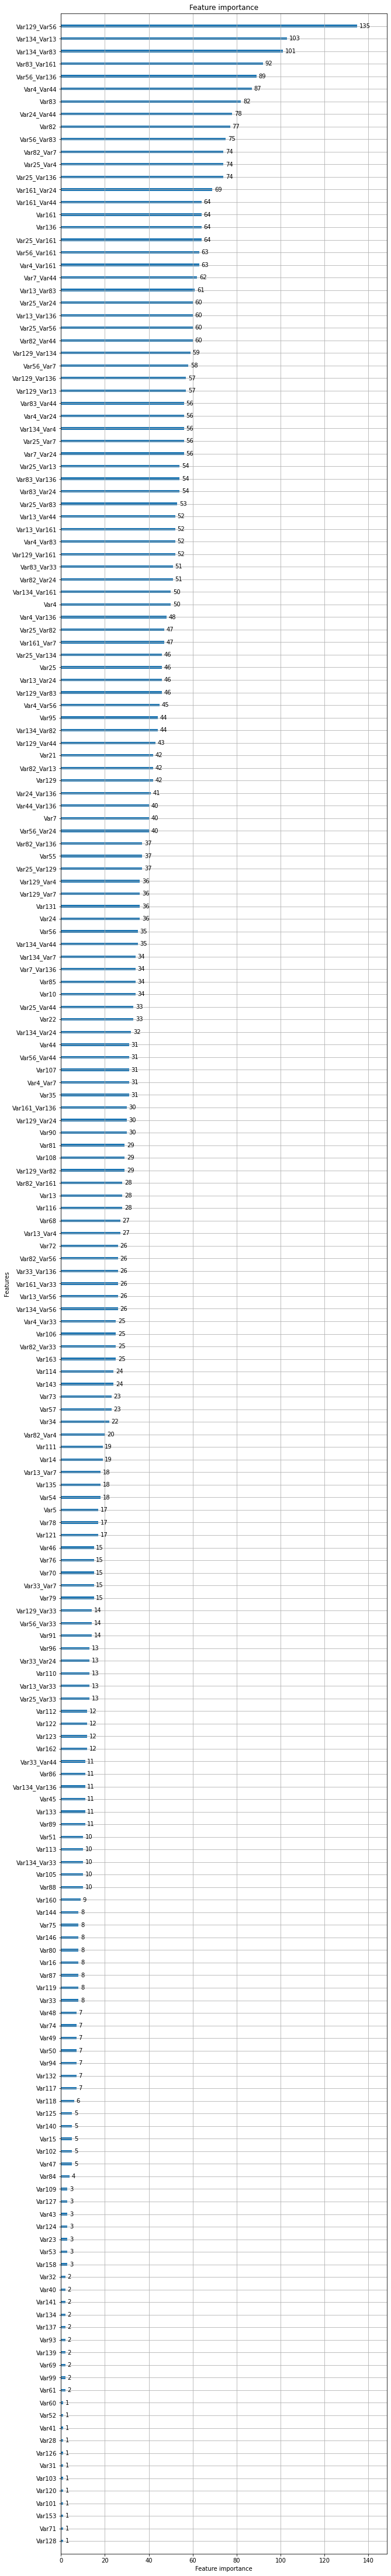

In [395]:
lgb.plot_importance(lgbm.best_estimator_['model'], figsize=(10, 80))

In [396]:
%%time
model = RandomForestClassifier(n_estimators=ESTIMATORS, class_weight='balanced_subsample')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__min_samples_leaf': [0.01, 0.02, 0.04],
    'model__max_features': ['log2'],
    'model__max_samples': [0.01, 0.05, 0.1],
}
# Defaults to StratifiedKFold
rf = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
rf.fit(x_train, y_train)
best_score = rf.best_score_
best_score_std = rf.cv_results_['std_test_score'][rf.best_index_]
print(f"""Random Forest
best params={repr(rf.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
""")
res = pd.DataFrame.from_dict(rf.cv_results_)
res.set_index('rank_test_score', inplace=True)
res.sort_index(inplace=True)

Random Forest
best params={'model__max_features': 'log2', 'model__max_samples': 0.05, 'model__min_samples_leaf': 0.01}
best score=0.715, std=0.072

CPU times: user 15.6 s, sys: 172 ms, total: 15.8 s
Wall time: 15.8 s


In [397]:
res.head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_features,param_model__max_samples,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,
1,0.326011,0.003451,0.028693,0.000722,log2,0.05,0.01,"{'model__max_features': 'log2', 'model__max_sa...",0.627144,0.641190,0.751733,0.820382,0.732789,0.714648,0.072024
2,0.378184,0.008178,0.030286,0.000834,log2,0.1,0.01,"{'model__max_features': 'log2', 'model__max_sa...",0.631153,0.618894,0.754108,0.831281,0.726524,0.712392,0.079267
3,0.347213,0.004358,0.028323,0.000713,log2,0.1,0.02,"{'model__max_features': 'log2', 'model__max_sa...",0.629894,0.612042,0.758506,0.803187,0.728312,0.706388,0.073918
4,0.307748,0.004675,0.026735,0.000768,log2,0.05,0.02,"{'model__max_features': 'log2', 'model__max_sa...",0.609183,0.606262,0.748482,0.819403,0.730690,0.702804,0.083120
5,0.329039,0.003830,0.026571,0.000367,log2,0.1,0.04,"{'model__max_features': 'log2', 'model__max_sa...",0.596364,0.609866,0.753343,0.814132,0.718097,0.698361,0.083726
6,0.287423,0.003592,0.024152,0.000371,log2,0.01,0.01,"{'model__max_features': 'log2', 'model__max_sa...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
6,0.283845,0.003387,0.023776,0.000283,log2,0.01,0.02,"{'model__max_features': 'log2', 'model__max_sa...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
6,0.284048,0.007036,0.023968,0.000610,log2,0.01,0.04,"{'model__max_features': 'log2', 'model__max_sa...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
6,0.298047,0.010443,0.026014,0.001908,log2,0.05,0.04,"{'model__max_features': 'log2', 'model__max_sa...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


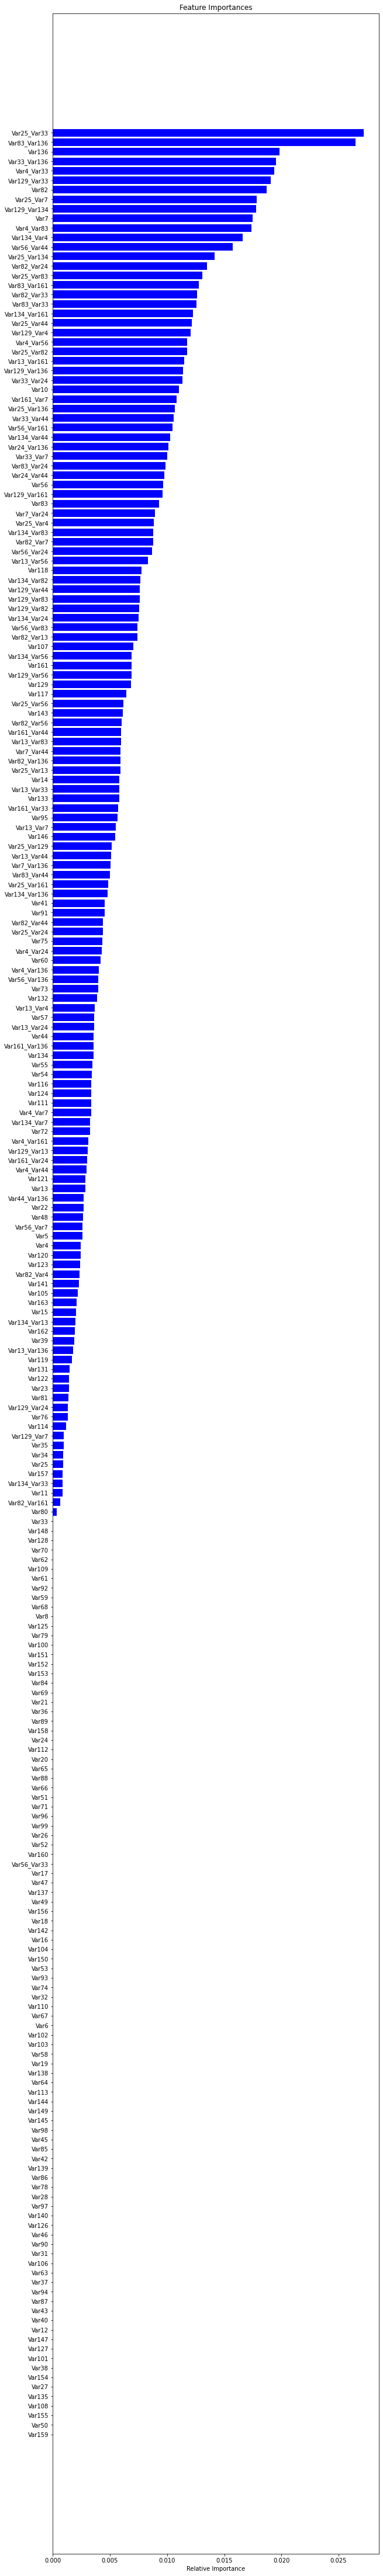

In [398]:
importances = rf.best_estimator_['model'].feature_importances_
plt.figure(figsize=(10,80))
plt.title("Feature importances")
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Test set evaluation

In [405]:
test['y_lgbm'] = lgbm.predict_proba(x_test)[:,1]
test['y_rf'] = rf.predict_proba(x_test)[:,1]
test['y_blend'] = 0.7 * test['y_lgbm'] + 0.3 * test['y_rf']
auc_lgbm = roc_auc_score(y_test, test['y_lgbm'], average='macro')
auc_rf = roc_auc_score(y_test, test['y_rf'], average='macro')
auc_blend = roc_auc_score(y_test, test['y_blend'], average='macro')
print(f'auc_blend={auc_blend:0.3f}, auc_lgbm={auc_lgbm:0.3f}, auc_rf={auc_rf:0.3f}')

auc_blend=0.625, auc_lgbm=0.635, auc_rf=0.615


In [406]:
res = test[test[TARGET] == 1].copy()
res.sort_values(by=['y_lgbm'], inplace=True, ascending=False)
res[[TARGET, 'y_blend', 'y_lgbm', 'y_rf']].head(10)

,Target,y_blend,y_lgbm,y_rf
ID,,,,
9904,1,0.285066,0.164265,0.566935
11423,1,0.273456,0.143596,0.576461
10668,1,0.254427,0.139599,0.522361
9641,1,0.243797,0.136010,0.495300
11821,1,0.254846,0.132902,0.539383
9914,1,0.198063,0.132138,0.351890
10850,1,0.206169,0.123421,0.399246
12609,1,0.225964,0.121846,0.468906
10638,1,0.229466,0.121379,0.481669
